# Testing Slope Fitting on Synthetic PSDs

Words, words, words.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats.mstats import normaltest

In [2]:
# Custom code imports
from slf import syn
from slf.fit import *
from slf.fake import *
from slf.plts.psd import *
from slf.plts.fake import _color_red_or_green

from slf.core.db import SLFDB
from slf.core.io import save_pickle, load_pickle

/Users/tom/anaconda/envs/eeg36/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
# Housekeeping
db = SLFDB()

# Check current path
db.syns_path

'/Users/tom/Documents/Research/1-Projects/Slope/2-Data/syns'

## Check out PSD generation and test fitting

In [4]:
# Generate a single synthetic test PSD
sl_val = 1
noise = 0.1
oscs = syn.gen_osc_def
fs, psd = syn.sim_psd([3, 40], sl_val, syn.gen_osc_def, noise)

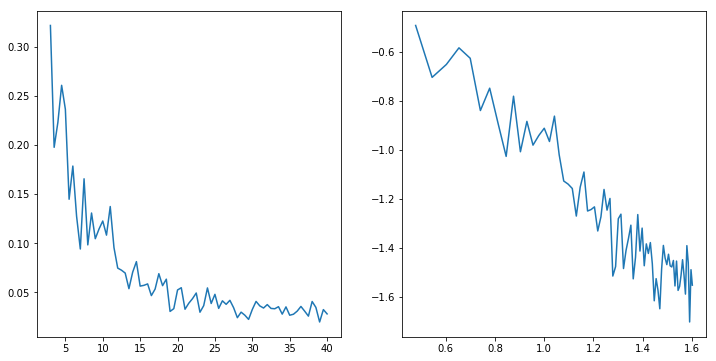

In [5]:
# Two subplots, the axes array is 1-d
plt_psd_both(fs, psd);

In [6]:
# Test out fits
print('True slope value is ', str(sl_val), '\n')
print('OLS fit: \t', fsl_ols(fs, psd))
print('RLM fit: \t', fsl_rlm(fs, psd))
print('RLM-EA fit: \t', fsl_rlm_alph(fs, psd))
print('RLM-EO fit: \t', fsl_rlm_oscs(fs, psd))
print('RAN fit: \t', fsl_ransac(fs, psd))
print('RAN-EA fit: \t', fsl_ransac_alph(fs, psd))
print('RAN-EO fit: \t', fsl_ransac_oscs(fs, psd))
print('EXP fit: \t', fsl_exp(fs, psd))
print('EXP-EA fit: \t', fsl_exp_alph(fs, psd))
print('EXP-EO fit: \t', fsl_exp_oscs(fs, psd))
print('FOOOF fit: \t', fsl_fooof(fs, psd))

True slope value is  1 

OLS fit: 	 -0.9449602003992671
RLM fit: 	 -0.9415614668427735
RLM-EA fit: 	 -0.9282384986839658
RLM-EO fit: 	 -1.571018841747972
RAN fit: 	 -1.0224989145758452
RAN-EA fit: 	 -0.8353061023491746
RAN-EO fit: 	 -1.716941849809793
EXP fit: 	 -0.9449602042348403
EXP-EA fit: 	 -0.9284570610233663
EXP-EO fit: 	 -1.504148927003504
FOOOF fit: 	 -0.9618530359663859


/Users/tom/anaconda/envs/eeg36/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


## Run a bunch of synthetic fits

In [7]:
# Settings
n_psds = 50
f_range = [3, 40]
sl_val = 1
noi_val = 0.05

# Simulate a group of PSDs
freqs, psds = syn.sim_n_psds(n_psds, f_range, sl_val, syn.gen_osc_def(), noi_val)

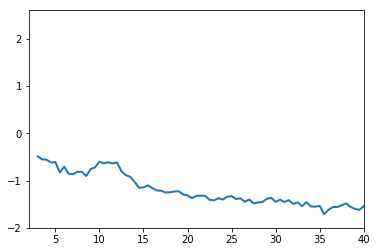

In [8]:
# Plot example synthetic PSD from the group
plt_psd_1(freqs, psds[:, 10], False)

In [9]:
# # Check out some of the synthetic plots
# for ind, psd in enumerate(psds.T):
#     if ind < 5:
#         plt.figure()
#         plt.plot(freqs, psd)

In [10]:
# Initialize and set up for synthetic data testing
syns = SynFits()
syns.get_fit_funcs()

In [11]:
# Check the fitting functions being used
print(list(syns.fit_funcs.keys()))

['OLS', 'RLM', 'RLM-EA', 'RLM-EO', 'RAN', 'RAN-EA', 'RAN-EO', 'EXP', 'EXP-EA', 'EXP-EO', 'FOOOF']


In [12]:
# Fit slopes - this fits all methods across the PSD
syns.fit_slopes(sl_val, freqs, psds)

In [13]:
# Calculate metrics
avgs = syns.calc_avg_errs()
perc_good = syns.calc_perc_good()

In [14]:
# Check errors per fitting method
print('AVERAGE SLOPE FITTING ERRORS')
print_res(avgs)

AVERAGE SLOPE FITTING ERRORS
   EXP-EO   		 0.01815
   RLM-EA   		 0.01840
   RAN-EO   		 0.01906
   EXP-EA   		 0.01970
   RLM-EO   		 0.02002
   FOOOF    		 0.02150
   RAN-EA   		 0.02388
   RAN      		 0.04216
   RLM      		 0.06757
   EXP      		 0.12555
   OLS      		 0.12555


In [15]:
# Check errors per fitting method
print('PERCENTAGE FITS BELOW ERROR THRESHOLD')
print_res(perc_good)

PERCENTAGE FITS BELOW ERROR THRESHOLD
   EXP-EO   		 0.70000
   RLM-EO   		 0.68000
   RLM-EA   		 0.68000
   EXP-EA   		 0.68000
   FOOOF    		 0.64000
   RAN-EO   		 0.62000
   RAN-EA   		 0.52000
   RAN      		 0.26000
   RLM      		 0.06000
   OLS      		 0.00000
   EXP      		 0.00000


In [16]:
# 
df = pd.DataFrame(syns.errs)

In [17]:
# Check the correlation structure between fit erros
df.corr()

,EXP,EXP-EA,EXP-EO,FOOOF,OLS,RAN,RAN-EA,RAN-EO,RLM,RLM-EA,RLM-EO
EXP,1.000000,0.343189,0.552598,0.467427,1.000000,0.691337,0.201109,0.314124,0.914542,0.201137,0.434057
EXP-EA,0.343189,1.000000,0.750626,0.665171,0.343189,0.369865,0.352183,0.468726,0.226608,0.926229,0.678104
EXP-EO,0.552598,0.750626,1.000000,0.924499,0.552598,0.506889,0.393214,0.715803,0.554467,0.699788,0.945672
FOOOF,0.467427,0.665171,0.924499,1.000000,0.467427,0.380684,0.338232,0.694360,0.500472,0.648572,0.897698
OLS,1.000000,0.343189,0.552598,0.467427,1.000000,0.691337,0.201109,0.314124,0.914542,0.201137,0.434057
RAN,0.691337,0.369865,0.506889,0.380684,0.691337,1.000000,0.164839,0.434976,0.710830,0.264838,0.445927
RAN-EA,0.201109,0.352183,0.393214,0.338232,0.201109,0.164839,1.000000,0.355279,0.277169,0.446730,0.473935
RAN-EO,0.314124,0.468726,0.715803,0.694360,0.314124,0.434976,0.355279,1.000000,0.399450,0.491248,0.732125
RLM,0.914542,0.226608,0.554467,0.500472,0.914542,0.710830,0.277169,0.399450,1.000000,0.166486,0.522429
RLM-EA,0.201137,0.926229,0.699788,0.648572,0.201137,0.264838,0.446730,0.491248,0.166486,1.000000,0.729809


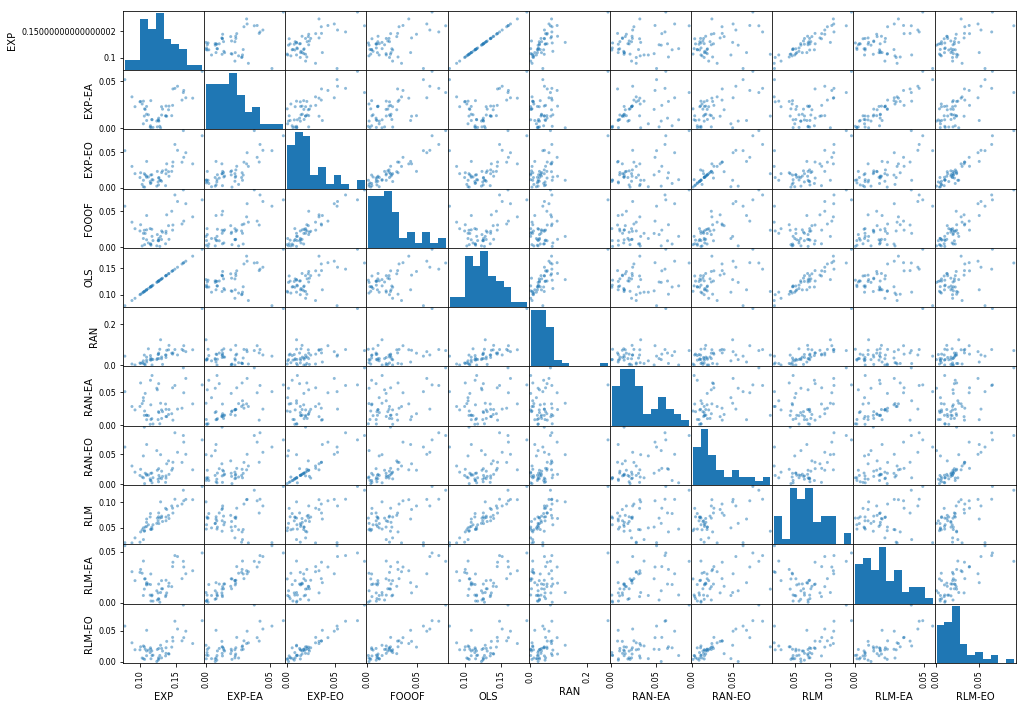

In [18]:
# Plot data distributions and inter-relations
pd.plotting.scatter_matrix(df, figsize=[16, 12]);

In [19]:
# Apply a normal test across fit-error distributions
normalities = df.apply(normaltest)

# Check which results of normal test
nt_df = pd.DataFrame([dat[1] for dat in normalities.values], index=normalities.index)
nt_df.style.applymap(_color_red_or_green)

,0
EXP,0.320355
EXP-EA,0.114241
EXP-EO,0.000145617
FOOOF,0.00785611
OLS,0.320355
RAN,1.88141e-13
RAN-EA,0.0844997
RAN-EO,0.00414957
RLM,0.669112
RLM-EA,0.189578


In [20]:
# Save out synthetic fit data to pickle
save_pickle(syns.errs, 'SynFits_test.p', db.syns_path)

In [21]:
# Check available synthetic fit files
syn_files = db.check_syns()
f_ind = syn_files.index('SynFits_test.p')

In [22]:
# Load synthetic fit data from pickle file
dat = load_pickle(syn_files[f_ind], db.syns_path)
syn_dat = SynFits()
syn_dat.errs = dat